In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [4]:
#static_ds = xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/ancil_fields/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')
#land_mask = static_ds.sftlf

# directories
metric_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/inference/output/metrics'
output_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/inference/output'

plot_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/plots/maps'

ccam_ds = xr.open_dataset('/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc')

In [5]:
'''
EVENTS
'''

boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity
 
# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)


def plot_CCAM(gcm,event):
    
    fig,ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)})
    
    ccam_da = ccam_ds.sel(GCM=gcm,time=event)['pr']
    ccam_da = ccam_da*86400 # convert from flux to mm/day
    im = ccam_da.squeeze().plot.contourf(ax=ax,add_colorbar=False,cmap=cmap,norm=norm,extend='max',transform=ccrs.PlateCarree())#cmap='viridis',vmin=0,vmax=200
    max_val = ccam_da.max().values.tolist()
    ax.text(0.8,0.2, f'MAX:\n{max_val:.0f}', va='center', ha='center',rotation='horizontal', transform=ax.transAxes,fontsize=16)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title('CCAM',fontsize=20)

    cb = fig.colorbar(im,shrink=0.8)
    cb.ax.tick_params(labelsize=16)
    cb.set_label('pr (mm/day)', fontsize=20)

    plt.savefig(f'maps/CCAM_{gcm}_{event}.png')
    plt.close()
    
def plot_NIWA_REMS(gcm,event,framework,ml_type):
        
    fig,ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)})

    if framework == 'perfect':
        da = xr.open_dataarray(f'/nesi/project/niwa00018/queenle/NIWA-REMS_inference/output/{gcm}/NIWA-REMS_v110425_pr/{gcm}_pr_ssp370_{framework}_framework_{ml_type}.nc')
    else:
        if event == '1987-03-26':
            da = xr.open_dataarray(f'/nesi/project/niwa00018/queenle/NIWA-REMS_inference/output/{gcm}/NIWA-REMS_v110425_pr/{gcm}_pr_historical_{framework}_framework_{ml_type}.nc')
        elif event == '2095-01-20':
            da = xr.open_dataarray(f'/nesi/project/niwa00018/queenle/NIWA-REMS_inference/output/{gcm}/NIWA-REMS_v110425_pr/{gcm}_pr_ssp370_{framework}_framework_{ml_type}.nc')

    da = da.sel(time=event).clip(0,1500)
    im = da.squeeze().plot.contourf(ax=ax,add_colorbar=False,cmap=cmap,norm=norm,extend='max',transform=ccrs.PlateCarree())#,cmap='viridis',vmin=0,vmax=200

    max_val = da.max().values.tolist()
    ax.text(0.8,0.2, f'MAX:\n{max_val:.0f}', va='center', ha='center',rotation='horizontal', transform=ax.transAxes,fontsize=16)
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title(f'NIWA-REMS ({ml_type})',fontsize=20)
    
    plt.savefig(f'maps/NIWA-REMS_{gcm}_{framework}_{event}_{ml_type}.png')
    plt.close()
    
def plot_ML(ax,gcm,sampling_n,framework,ml_type,epoch,event):
    
    if framework == 'perfect':
        da = xr.open_dataarray(f'{output_dir}/{gcm}/pr_ACCESS-CM2_{sampling_n}/{gcm}_pr_ssp370_{framework}_framework_{ml_type}_epoch_{epoch}.nc')
    else:
        if event == '1987-03-26':
            da = xr.open_dataarray(f'{output_dir}/{gcm}/pr_ACCESS-CM2_{sampling_n}/{gcm}_pr_historical_{framework}_framework_{ml_type}_epoch_{epoch}.nc')
        elif event == '2095-01-20':
            da = xr.open_dataarray(f'{output_dir}/{gcm}/pr_ACCESS-CM2_{sampling_n}/{gcm}_pr_ssp370_{framework}_framework_{ml_type}_epoch_{epoch}.nc')

    da = da.sel(time=event).clip(0,1500)
    im = da.squeeze().plot.contourf(ax=axs[i][j],add_colorbar=False,cmap=cmap,norm=norm,extend='max',transform=ccrs.PlateCarree())#,cmap='viridis',vmin=0,vmax=200

    max_val = da.max().values.tolist()
    ax.text(0.8,0.2, f'MAX:\n{max_val:.0f}', va='center', ha='center',rotation='horizontal', transform=ax.transAxes,fontsize=16)
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title('')
    
    return(im)

gcm = 'NorESM2-MM'
epoch = 230
extent = [164, 184, -52, -32]
event1 = '1987-03-26'
event2 = '2095-01-20'

for event in [event1,event2]:
    # plot CCAM 
    #plot_CCAM(gcm,event)

    # plot ML results
    for framework in ['perfect','imperfect']:
        fig,axs = plt.subplots(2,5,figsize=(12,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)},layout='constrained')

        for i,ml_type in enumerate(['GAN','unet']):
            # plot NIWA-REMS
            #plot_NIWA_REMS(gcm,event,framework,ml_type)

            for j,sampling_n in enumerate(['5','20','50','100','140']):

                im = plot_ML(axs[i][j],gcm,sampling_n,framework,ml_type,epoch,event)

                if i == 0:
                    axs[i][j].set_title(sampling_n,fontsize=20)

                if j == 0:
                    axs[i][j].text(-0.1, 0.5, ml_type, va='center', ha='center',rotation='vertical', transform=axs[i][j].transAxes,fontsize=20)

        cb = fig.colorbar(im,ax=axs[:, :],shrink=0.8)
        cb.ax.tick_params(labelsize=16)
        cb.set_label('pr (mm/day)', fontsize=20)

        plt.savefig(f'{plot_dir}/{gcm}_{framework}_{event}_epoch_{epoch}.png')
        plt.close()

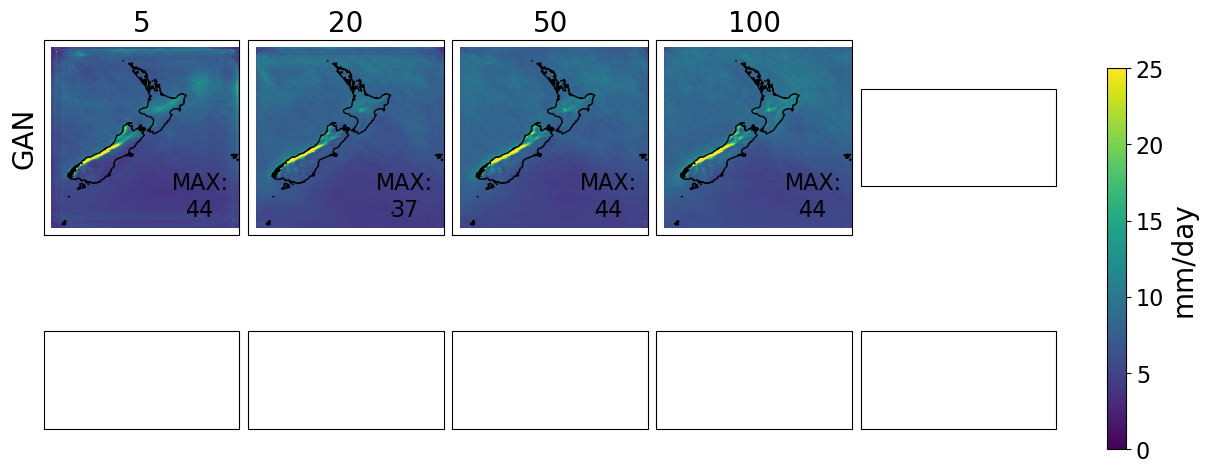

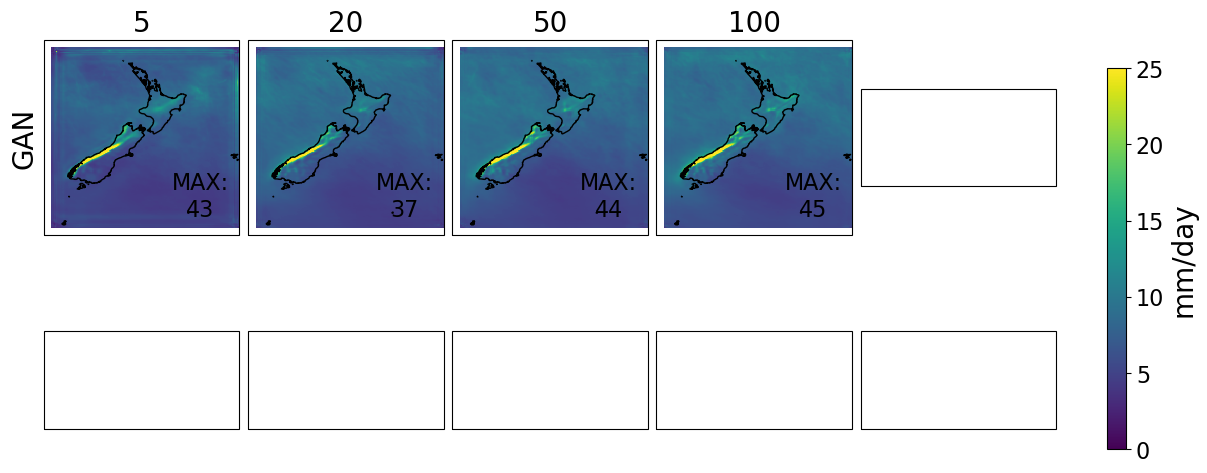

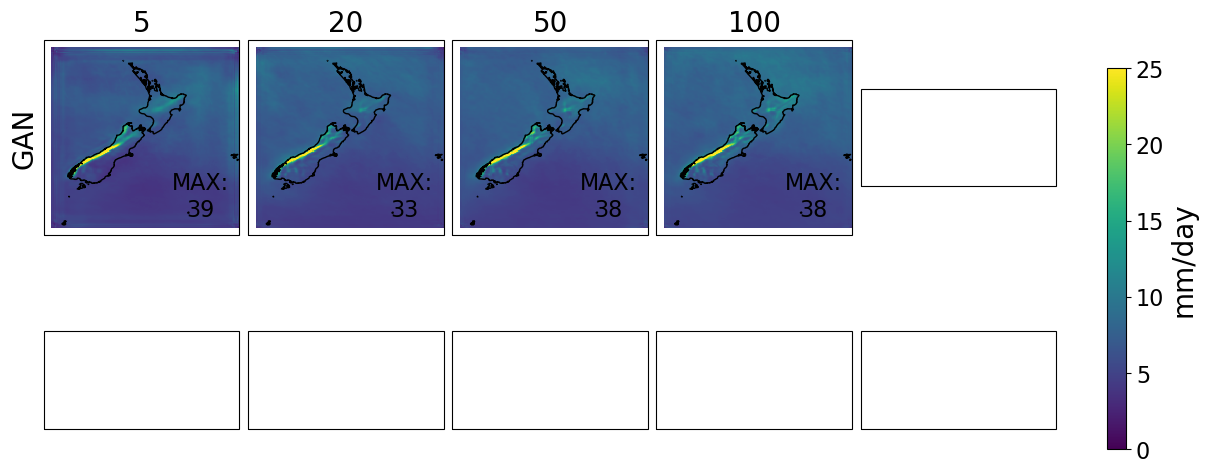

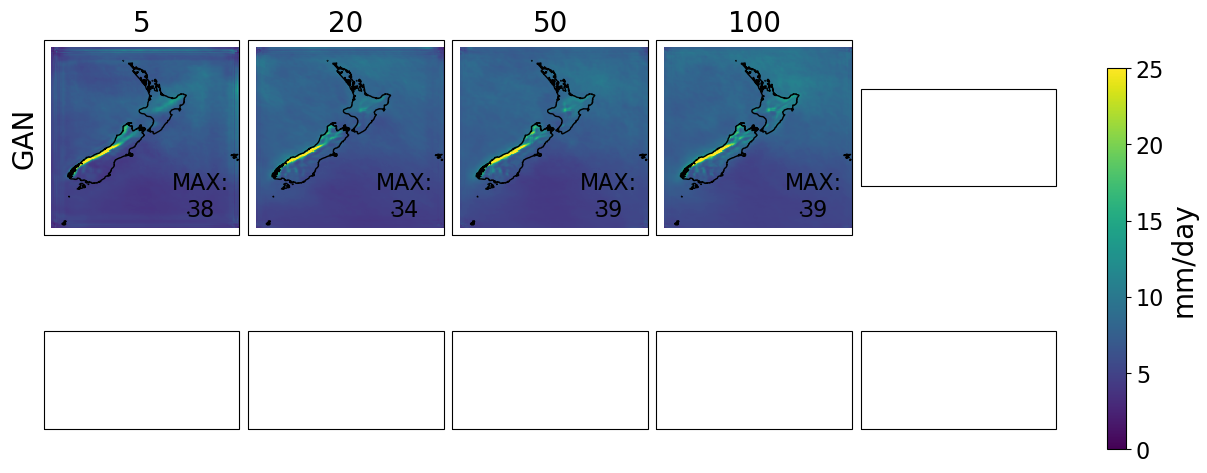

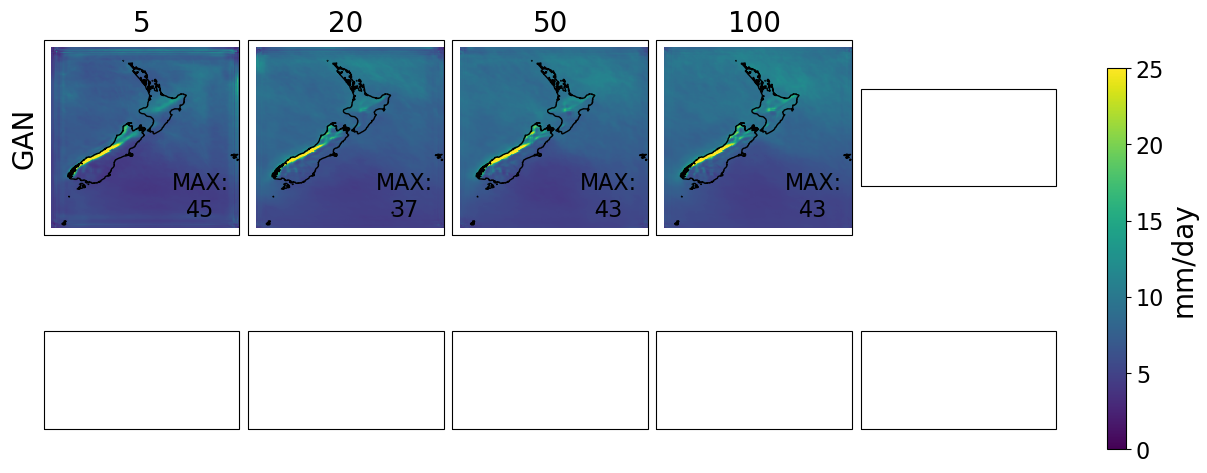

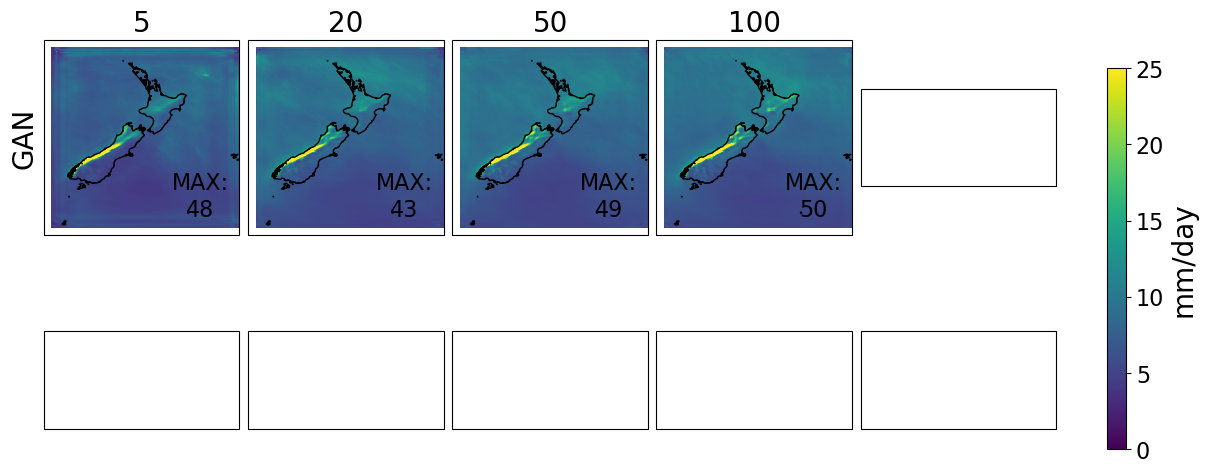

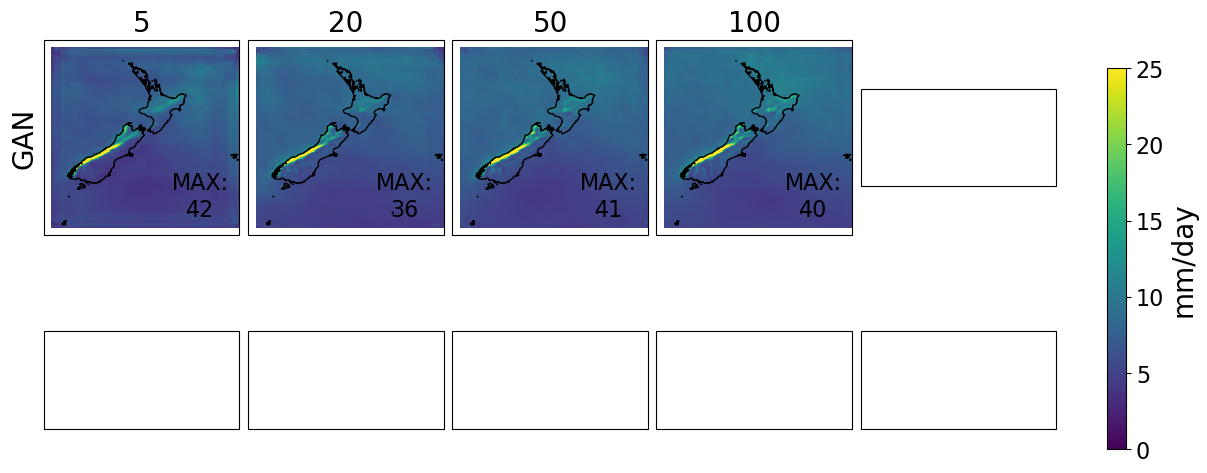

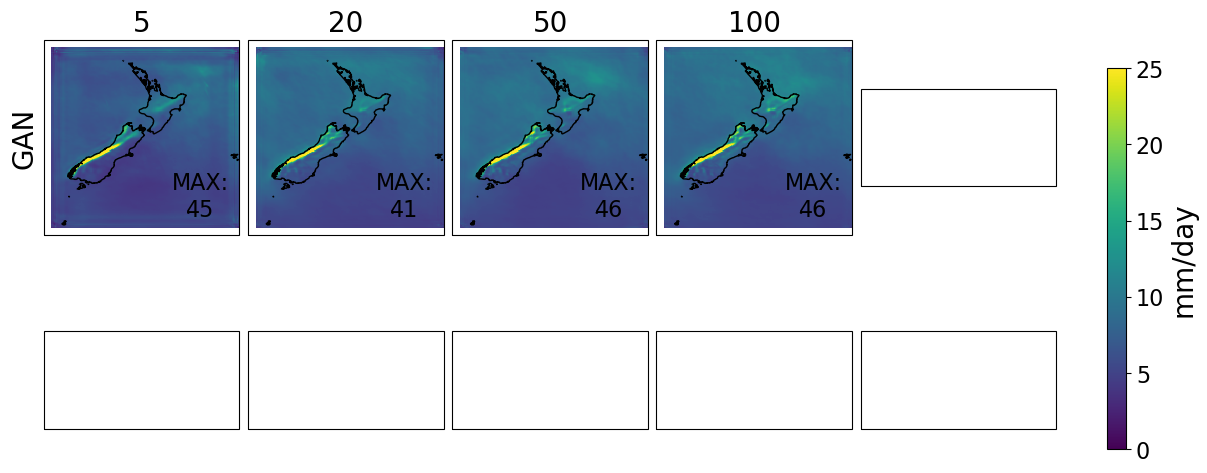

In [9]:
'''
CLIMOS
'''

def plot_map(ax,gcm,sampling_n,framework,ml_type,epoch,metric):
    
    ds = xr.open_dataset(f'{metric_dir}/{gcm}/pr_ACCESS-CM2_{sampling_n}/{gcm}_{framework}_pr_metrics_{ml_type}_epoch_{epoch}.nc')

    da = ds[f'{metric}_{period}']
    
    im = da.plot(ax=axs[i][j],vmin=0,vmax=v_val,add_colorbar=False,cmap='viridis',transform=ccrs.PlateCarree())

    max_val = da.max().values.tolist()
    ax.text(0.8,0.2, f'MAX:\n{max_val:.0f}', va='center', ha='center',rotation='horizontal', transform=ax.transAxes,fontsize=16)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title('')
    
    return(im)

def plot_CCAM(gcm,metric,period):
    
    fig,ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)})
    ccam_metrics = xr.open_dataset(f'{metric_dir}/{gcm}/CCAM/{gcm}_pr_metrics.nc')
    ccam_da = ccam_metrics[f'{metric}_{period}']

    im = ccam_da.plot(ax=ax,vmin=0,vmax=v_val,add_colorbar=False,cmap='viridis',transform=ccrs.PlateCarree())

    max_val = ccam_da.max().values.tolist()
    ax.text(0.8,0.2, f'MAX:\n{max_val:.0f}', va='center', ha='center',rotation='horizontal', transform=ax.transAxes,fontsize=16)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title('CCAM',fontsize=20)

    cb = fig.colorbar(im,shrink=0.8)
    cb.ax.tick_params(labelsize=16)
    cb.set_label('mm/day', fontsize=20)

    plt.savefig(f'maps/CCAM_{gcm}_{metric}_{period}.png')
    plt.close()

    

#gcm = 'EC-Earth3'
epoch = 230
metric = 'rx1d'
#period = '2080-2099'#'1985-2004'
extent = [164, 184, -52, -32]
v_val = 150#25 SDII, 500 total max, 150 rx1d

for gcm in ['EC-Earth3','NorESM2-MM']:
    for period in ['2080-2099','1985-2004']:
        # plot CCAM 
        #plot_CCAM(gcm,metric,period)

        # ML MAPS
        for framework in ['perfect','imperfect']:
            fig,axs = plt.subplots(2,5,figsize=(12,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)},layout='constrained')
            for i,ml_type in enumerate(['GAN']):#,'unet']):

                for j,sampling_n in enumerate(['5','20','50','100','140']):

                    im = plot_map(axs[i][j],gcm,sampling_n,framework,ml_type,epoch,metric)

                    if i == 0:
                        axs[i][j].set_title(sampling_n,fontsize=20)

                    if j == 0:
                        axs[i][j].text(-0.1, 0.5, ml_type, va='center', ha='center',rotation='vertical', transform=axs[i][j].transAxes,fontsize=20)


            cb = fig.colorbar(im,ax=axs[:, :],shrink=0.8)
            cb.ax.tick_params(labelsize=16)
            cb.set_label('mm/day', fontsize=20)

            #plt.savefig(f'maps/{gcm}_{framework}_{metric}_{period}_epoch_{epoch}.png')
            #plt.close()

In [4]:
'''
CC SIGNALS
'''

def plot_map(ax,gcm,sampling_n,framework,ml_type,epoch,metric):
    
    ds = xr.open_dataset(f'{metric_dir}/{gcm}/pr_ACCESS-CM2_{sampling_n}/{gcm}_{framework}_pr_metrics_{ml_type}_epoch_{epoch}.nc')

    da = get_CC_signal(ds,metric)
    
    im = da.plot(ax=axs[i][j],vmin=-range_v[metric],vmax=range_v[metric],add_colorbar=False,cmap='RdBu_r',transform=ccrs.PlateCarree())

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.set_title('')
    
    return(im)
    
    
def get_CC_signal(ds,metric):
    
    base_period = ds[f'{metric}_1985-2004']
    future_period = ds[f'{metric}_2080-2099']
    
    CC_signal = ((future_period - base_period)/base_period) * 100
        
    return(CC_signal)
    

#gcm = 'EC-Earth3'
epoch = 130
#metric = 'JJA_mean'
extent = [164, 184, -52, -32]
range_v = {'annual_mean':50,'DJF_mean':50,'JJA_mean':40,'rx1d':70}

for gcm in ['ACCESS-CM2','NorESM2-MM','EC-Earth3']:
    for metric in ['annual_mean','DJF_mean','JJA_mean','rx1d']:
        # plot CCAM 
        fig,ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)})
        ccam_metrics = xr.open_dataset(f'{metric_dir}/{gcm}/CCAM/{gcm}_pr_metrics.nc')
        ccam_da = get_CC_signal(ccam_metrics,metric)

        im = ccam_da.plot(ax=ax,vmin=-range_v[metric],vmax=range_v[metric],add_colorbar=False,cmap='RdBu_r',transform=ccrs.PlateCarree())

        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines(resolution='10m')
        ax.set_title('CCAM',fontsize=20)

        cb = fig.colorbar(im,shrink=0.8)
        cb.ax.tick_params(labelsize=16)
        cb.set_label('%', fontsize=20)

        plt.savefig(f'maps/CCAM_{gcm}_{metric}_CC_signal.png')
        plt.close()


        # ML MAPS
        for framework in ['perfect','imperfect']:
            fig,axs = plt.subplots(2,5,figsize=(12,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=175)},layout='constrained')
            for i,ml_type in enumerate(['GAN','unet']):

                for j,sampling_n in enumerate(['5','20','50','100','140']):

                    plot_map(axs[i][j],gcm,sampling_n,framework,ml_type,epoch,metric)

                    if i == 0:
                        axs[i][j].set_title(sampling_n,fontsize=20)

                    if j == 0:
                        axs[i][j].text(-0.1, 0.5, ml_type, va='center', ha='center',rotation='vertical', transform=axs[i][j].transAxes,fontsize=20)


            cb = fig.colorbar(im,ax=axs[:, :],shrink=0.8)
            cb.ax.tick_params(labelsize=16)
            cb.set_label('%', fontsize=20)

            plt.savefig(f'maps/{gcm}_{framework}_{metric}_CC_signal_epoch_{epoch}.png')
            plt.close()

NameError: name 'plot_dir' is not defined

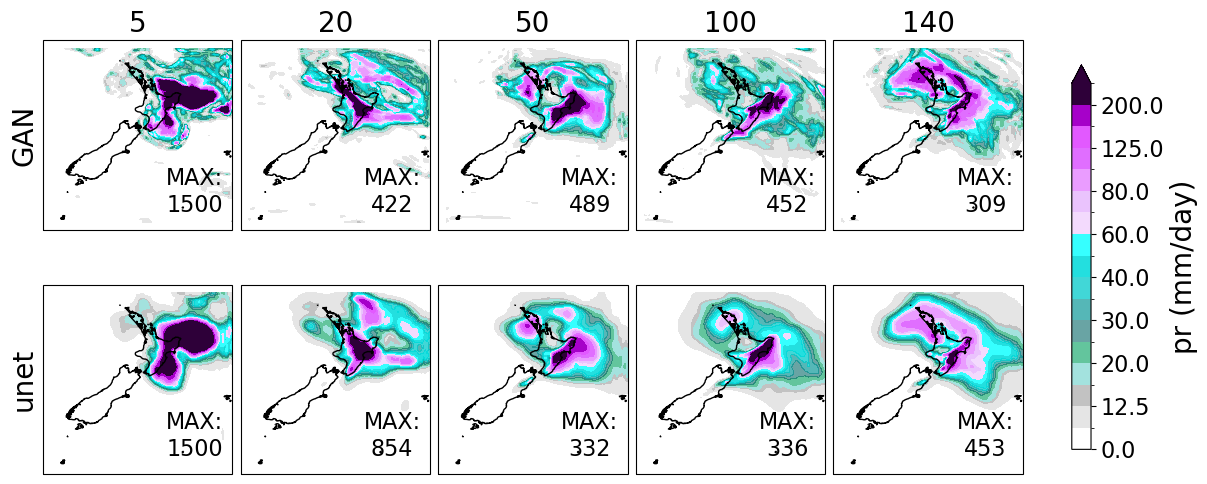